In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index


In [2]:
df = pd.read_csv("E:/DATN_LVTN/SA/clinical_data.csv")
df.head()

,Case ID,Patient affiliation,Age at Histological Diagnosis,Weight (lbs),Gender,Ethnicity,Smoking status,%GG,Tumor Location (choice=RUL),Tumor Location (choice=RML),Tumor Location (choice=RLL),Tumor Location (choice=LUL),Tumor Location (choice=LLL),Tumor Location (choice=L Lingula),Tumor Location (choice=Unknown),Histology,Pathological T stage,Pathological N stage,Pathological M stage,Histopathological Grade,Lymphovascular invasion,"Pleural invasion (elastic, visceral, or parietal)",EGFR mutation status,KRAS mutation status,ALK translocation status,Adjuvant Treatment,Chemotherapy,Radiation,Recurrence,Days between CT and surgery,Time_to_Event,Event
0,R01-001,Stanford,79,146.0,Female,Caucasian,Former,0%,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Adenocarcinoma,T1a,N0,M0,G2 Moderately differentiated,Absent,No,Unknown,Unknown,Unknown,No,No,No,no,42,3078,0
1,R01-002,Stanford,65,195.0,Female,Asian,Nonsmoker,0%,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Adenocarcinoma,T1a,N0,M0,G1 Well differentiated,Absent,No,Unknown,Unknown,Unknown,No,No,No,no,23,70,0
2,R01-003,VA,65,173.5,Male,Caucasian,Current,0%,Unchecked,Unchecked,Unchecked,Unchecked,Checked,Unchecked,Unchecked,Adenocarcinoma,T3,N0,M0,"Other, Type I: Well to moderately differentiated",Absent,No,Mutant,Mutant,Wildtype,No,No,No,no,25,666,0
3,R01-004,VA,67,173.5,Male,Caucasian,Former,0%,Unchecked,Unchecked,Unchecked,Checked,Unchecked,Unchecked,Unchecked,Squamous cell carcinoma,T1b,N2,M0,G2 Moderately differentiated,Absent,No,Wildtype,Wildtype,Wildtype,Yes,Yes,Yes,yes,89,1172,0
4,R01-005,Stanford,84,145.0,Male,Native Hawaiian/Pacific Islander,Former,0%,Unchecked,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Adenocarcinoma,T2a,N0,M0,G3 Poorly differentiated,Absent,No,Wildtype,Unknown,Wildtype,No,No,No,yes,92,1456,1


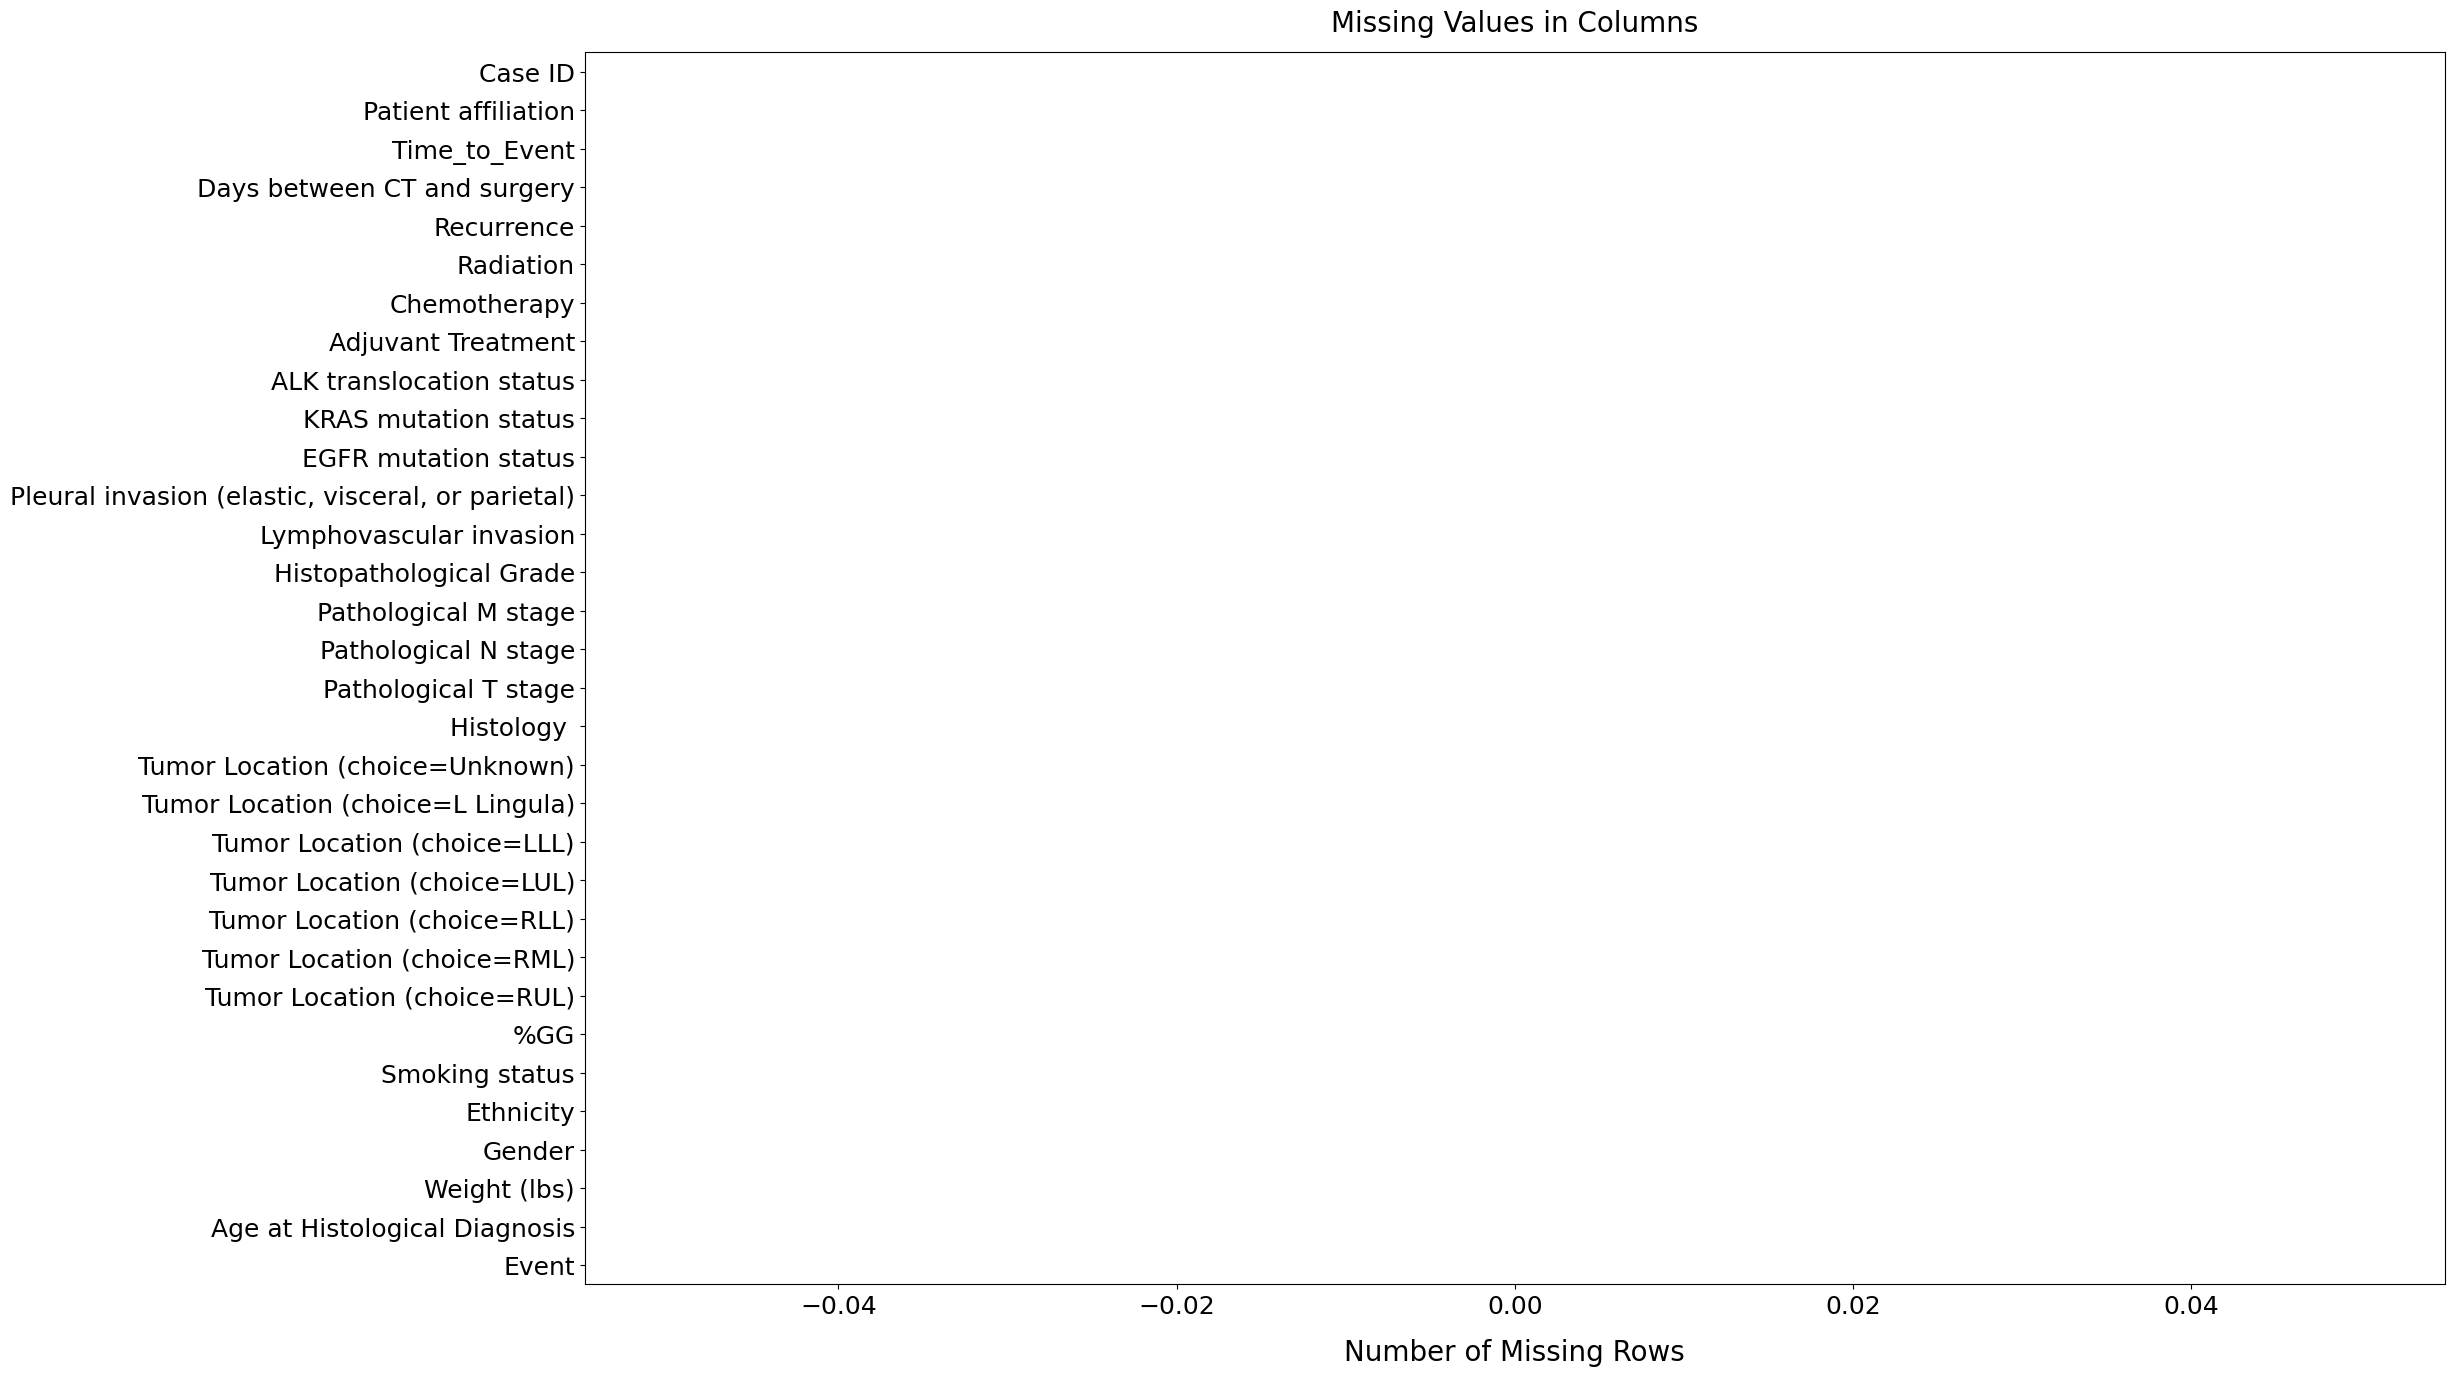

In [3]:
fig = plt.figure(figsize=(24, 16))

sns.barplot(x=df.isnull().sum().sort_values(ascending=False).values,
            y=df.isnull().sum().sort_values(ascending=False).index,
            palette='Reds_d')

plt.xlabel('Number of Missing Rows', size=20, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Missing Values in Columns', size=20, pad=15)

plt.show()

In [35]:
object_cols = ['Gender', 'Ethnicity', 'Smoking status',
               '%GG', 'Tumor Location (choice=RUL)', 'Tumor Location (choice=RML)', 'Tumor Location (choice=RLL)', 'Tumor Location (choice=LUL)',
               'Tumor Location (choice=LLL)', 'Tumor Location (choice=L Lingula)', 'Tumor Location (choice=Unknown)',
               'Pathological T stage', 'Pathological N stage', 'Pathological M stage', 'Histopathological Grade', 'Lymphovascular invasion',
               'Pleural invasion (elastic, visceral, or parietal)', 'EGFR mutation status', 'KRAS mutation status', 'ALK translocation status', 'Adjuvant Treatment',
               'Chemotherapy', 'Radiation', 'Recurrence']

for col in object_cols:
    df[col] = np.uint8(LabelEncoder().fit_transform(df[col]))
    
df['Histology '] = np.uint8(df['Histology '].map({'Adenocarcinoma': 0, 'Squamous cell carcinoma': 1, 'NSCLC NOS (not otherwise specified)': 2}))
df.head()

,Age at Histological Diagnosis,Weight (lbs),Gender,Ethnicity,Smoking status,%GG,Tumor Location (choice=RUL),Tumor Location (choice=RML),Tumor Location (choice=RLL),Tumor Location (choice=LUL),Tumor Location (choice=LLL),Tumor Location (choice=L Lingula),Tumor Location (choice=Unknown),Histology,Pathological T stage,Pathological N stage,Pathological M stage,Histopathological Grade,Lymphovascular invasion,"Pleural invasion (elastic, visceral, or parietal)",EGFR mutation status,KRAS mutation status,ALK translocation status,Adjuvant Treatment,Chemotherapy,Radiation,Recurrence,Days between CT and surgery,Time_to_Event,Event
0,79,146.0,0,2,1,0,0,1,1,1,1,1,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,42,3078,0
1,65,195.0,0,1,2,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,23,70,0
2,65,173.5,1,2,0,0,1,1,1,1,0,1,0,0,4,0,0,3,0,0,0,0,2,0,0,0,0,25,666,0
3,67,173.5,1,2,1,0,1,1,1,0,1,1,0,0,1,2,0,1,0,0,2,2,2,1,1,1,1,89,1172,0
4,84,145.0,1,4,1,0,1,0,1,1,1,1,0,0,2,0,0,2,0,0,2,1,2,0,0,0,1,92,1456,1


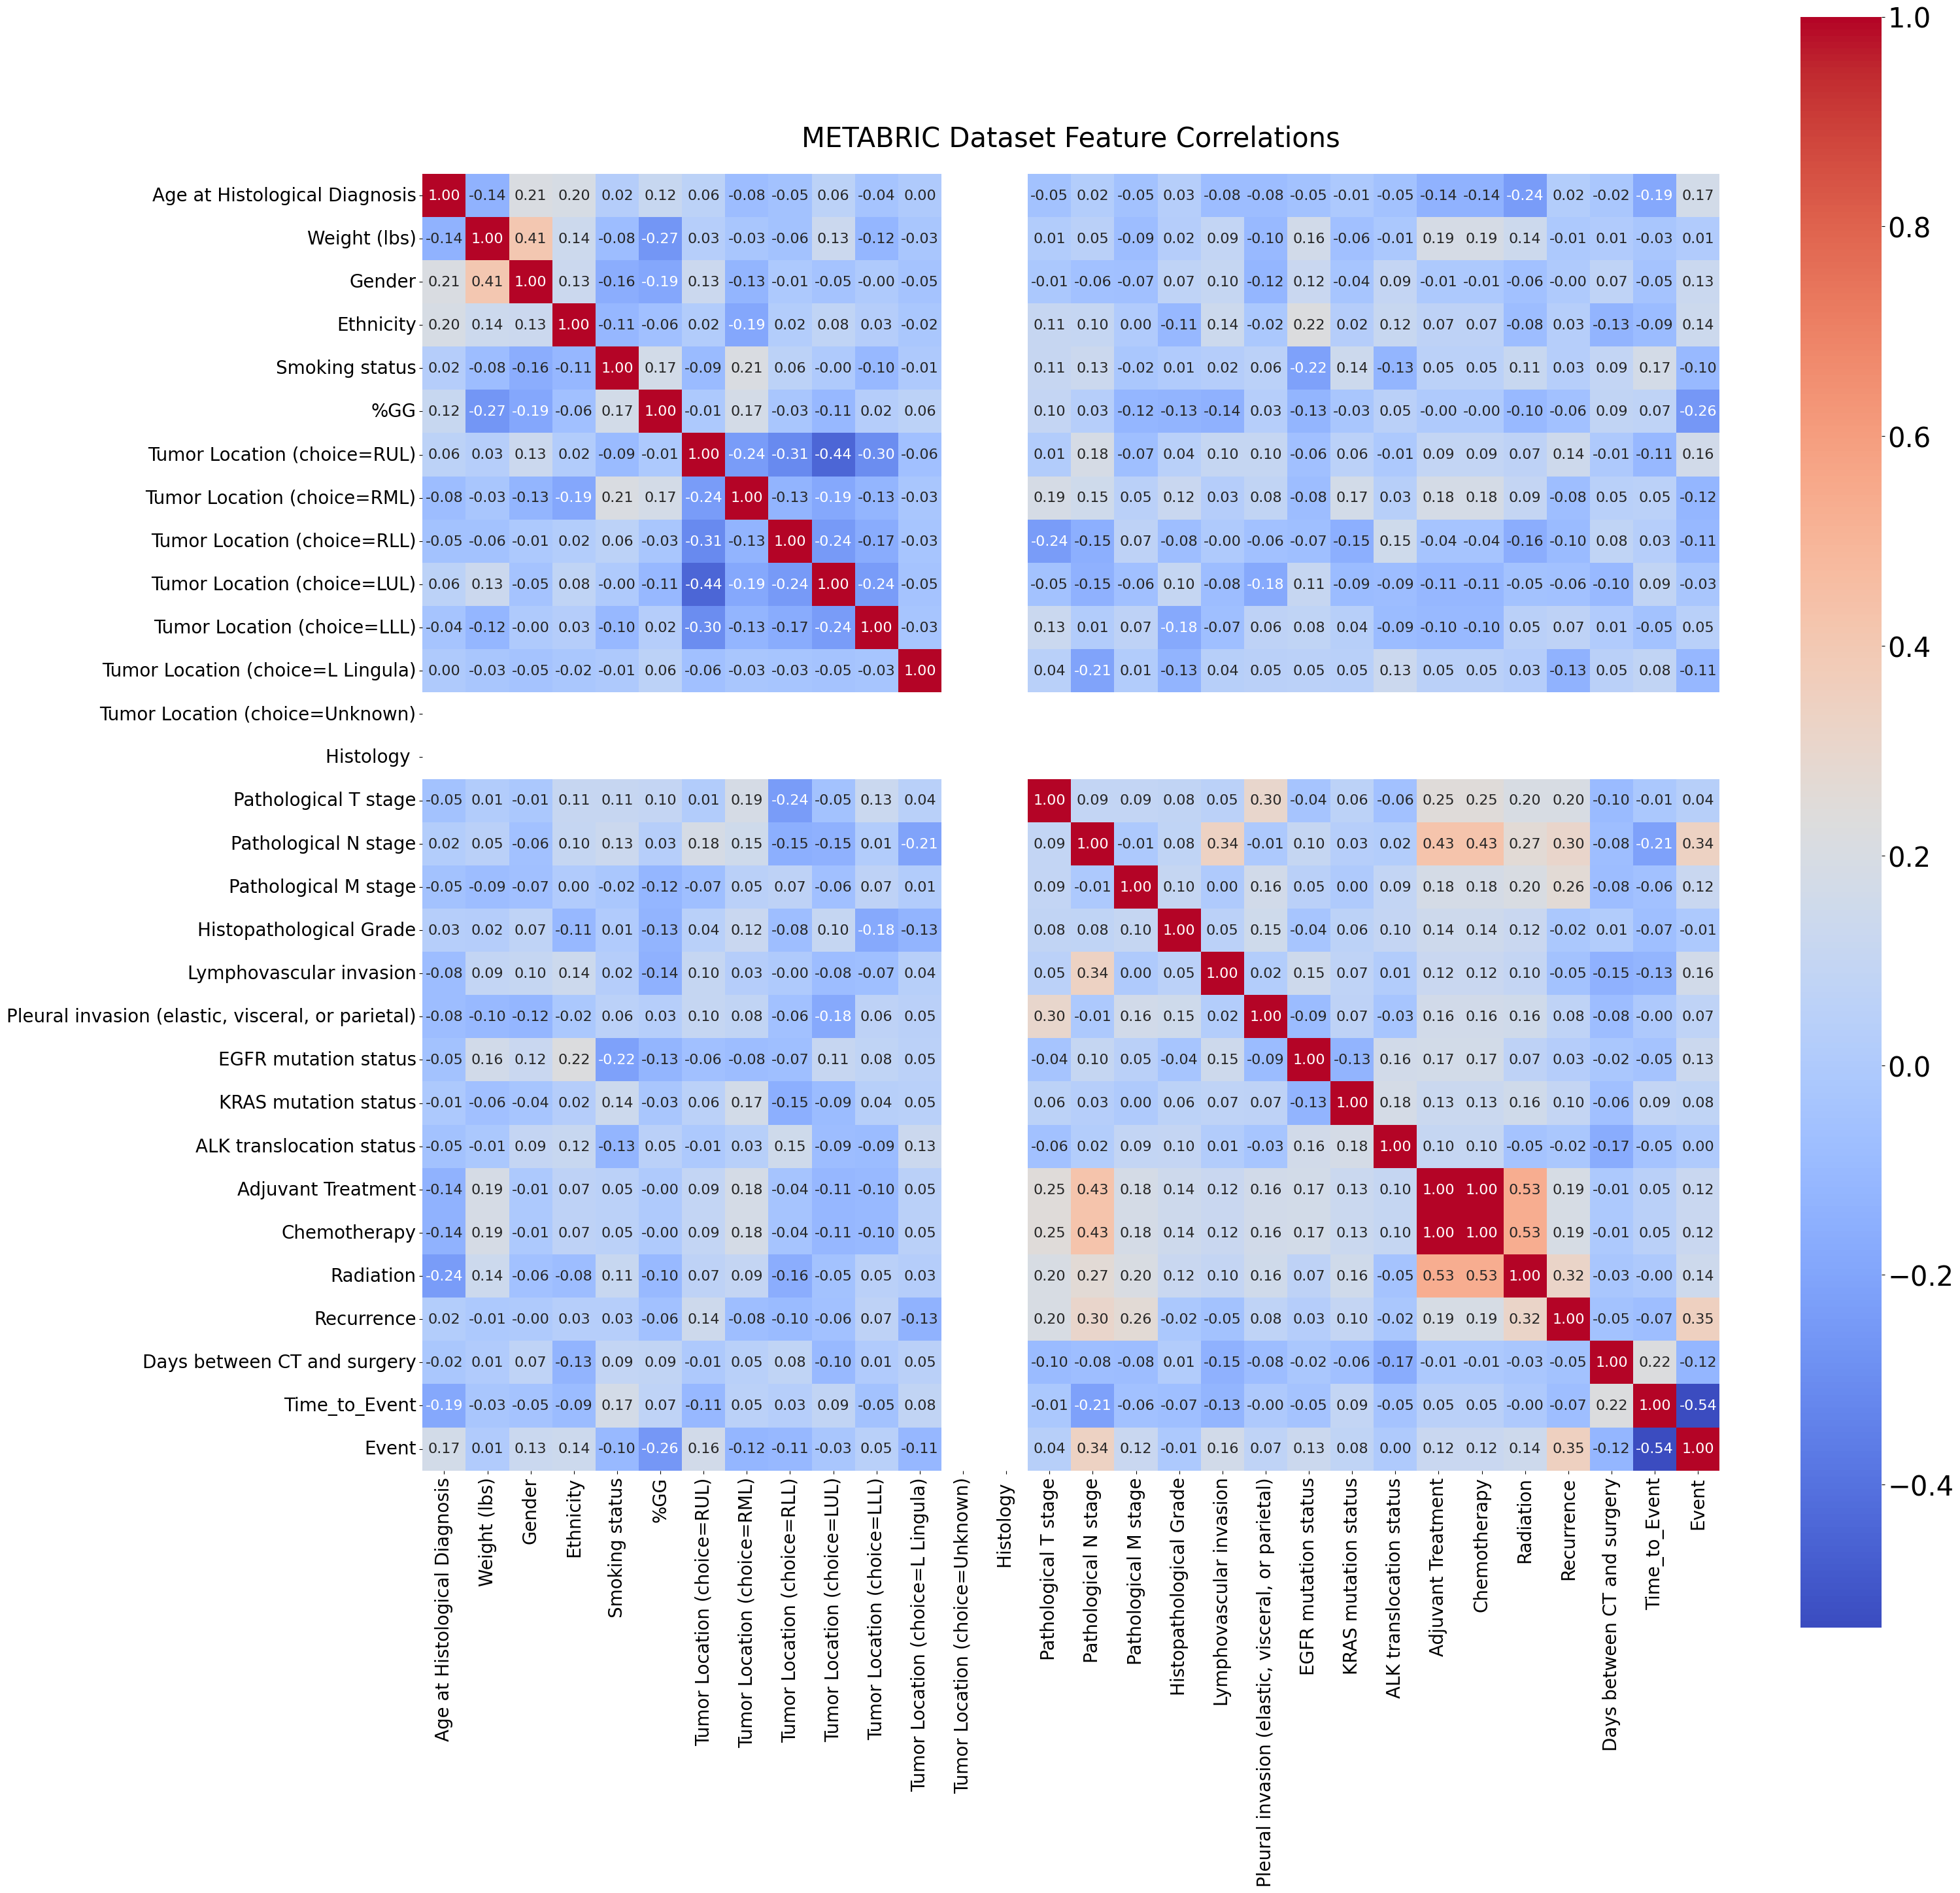

In [36]:
fig = plt.figure(figsize=(32, 32), dpi=100)

ax = sns.heatmap(df.corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 16},  fmt='.2f')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20, rotation=0)
plt.title('METABRIC Dataset Feature Correlations', size=30, pad=30)

plt.show()